In [ ]:
!kaggle kernels output datam0nstr/toxic-comment-classification -p /content/toxic_output


Output file downloaded to /content/toxic_output/best_model/added_tokens.json
Output file downloaded to /content/toxic_output/best_model/config.json
Output file downloaded to /content/toxic_output/best_model/model.safetensors
Output file downloaded to /content/toxic_output/best_model/special_tokens_map.json
Output file downloaded to /content/toxic_output/best_model/spm.model
Output file downloaded to /content/toxic_output/best_model/tokenizer.json
Output file downloaded to /content/toxic_output/best_model/tokenizer_config.json
Output file downloaded to /content/toxic_output/submission.csv
Kernel log downloaded to /content/toxic_output/toxic-comment-classification.log 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installing and Importing Libraries

In [ ]:
# ====================================================
# 1. INSTALL AND UPGRADE LIBRARIES (IMPORTANT!)
# ====================================================
!pip install -q --upgrade \
    transformers \
    tokenizers \
    datasets \
    evaluate \
    accelerate \
    torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
# ====================================================
# TOXIC COMMENT INFERENCE (Colab Version)
# ====================================================

import torch
import re
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ====================================================
# CONFIGURATION
# ====================================================
MODEL_PATH = "/content/toxic_output/best_model"  # Path to your trained model
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
MAX_LEN = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ====================================================
# CLEANING FUNCTION (same as training)
# ====================================================
def clean_text(text):
    if not isinstance(text, str):
        return ""
    url_pattern = r"http\S+|www\.\S+"
    html_pattern = r"<.*?>"
    emoji_pattern = r"[\U00010000-\U0010ffff]"
    non_ascii_pattern = r"[^\x00-\x7F]+"
    multi_space_pattern = r"\s+"

    text = text.lower()
    text = re.sub(url_pattern, " ", text)
    text = re.sub(html_pattern, " ", text)
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(non_ascii_pattern, " ", text)
    text = re.sub(multi_space_pattern, " ", text).strip()
    return text


# ====================================================
# LOAD MODEL & TOKENIZER
# ====================================================
print(f"📦 Loading model from: {MODEL_PATH}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

model.to(device)
model.eval()


# ====================================================
# INFERENCE FUNCTION
# ====================================================
def predict_toxicity(text):
    cleaned = clean_text(text)
    inputs = tokenizer(
        cleaned,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

    results = {label: float(prob) for label, prob in zip(LABELS, probs)}
    return results


# ====================================================
# EXAMPLE USAGE
# ====================================================
# 🟢 Single Example
example_text = "You are such an idiot!"
predictions = predict_toxicity(example_text)

print(f"\n💬 Input Text:\n{example_text}")
print("\n--- Toxicity Probabilities ---")
for label, prob in predictions.items():
    print(f"{label:15s}: {prob:.4f}")

# 🟡 Optional: Interactive Input
# You can uncomment below to interact manually in Colab:
# while True:
#     text = input("\nEnter a comment (or 'quit' to exit): ")
#     if text.lower().strip() == "quit":
#         break
#     preds = predict_toxicity(text)
#     print("\n--- Toxicity Probabilities ---")
#     for label, prob in preds.items():
#         print(f"{label:15s}: {prob:.4f}")


✅ Using device: cuda
📦 Loading model from: /content/toxic_output/best_model

💬 Input Text:
You are such an idiot!

--- Toxicity Probabilities ---
toxic          : 0.9870
severe_toxic   : 0.0528
obscene        : 0.8515
threat         : 0.0016
insult         : 0.8350
identity_hate  : 0.0513


✅ Using device: cuda
📦 Loading model with attentions from: /content/toxic_output/best_model


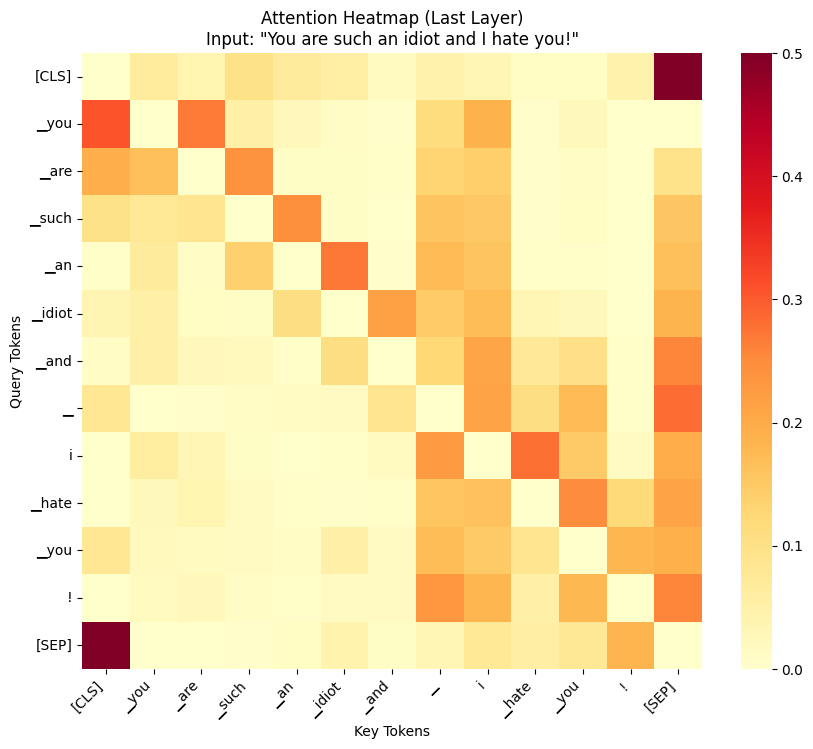


--- Toxicity Probabilities ---
toxic          : 0.9924
severe_toxic   : 0.1160
obscene        : 0.9076
threat         : 0.0045
insult         : 0.8743
identity_hate  : 0.0856


In [ ]:
# ====================================================
# ATTENTION VISUALIZATION (Colab Version)
# ====================================================

import torch
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ====================================================
# CONFIG
# ====================================================
MODEL_PATH = "/content/toxic_output/best_model"
MAX_LEN = 128  # shorter for visualization clarity
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ====================================================
# CLEANING FUNCTION
# ====================================================
def clean_text(text):
    if not isinstance(text, str):
        return ""
    url_pattern = r"http\S+|www\.\S+"
    html_pattern = r"<.*?>"
    emoji_pattern = r"[\U00010000-\U0010ffff]"
    non_ascii_pattern = r"[^\x00-\x7F]+"
    multi_space_pattern = r"\s+"

    text = text.lower()
    text = re.sub(url_pattern, " ", text)
    text = re.sub(html_pattern, " ", text)
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(non_ascii_pattern, " ", text)
    text = re.sub(multi_space_pattern, " ", text).strip()
    return text


# ====================================================
# LOAD MODEL & TOKENIZER (with attentions)
# ====================================================
print(f"📦 Loading model with attentions from: {MODEL_PATH}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()


# ====================================================
# FUNCTION TO COMPUTE ATTENTION
# ====================================================
def visualize_attention(text):
    cleaned = clean_text(text)
    inputs = tokenizer(
        cleaned,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt",
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy().flatten()
        attentions = outputs.attentions  # tuple of layers, each (batch, heads, seq_len, seq_len)

    # Take the last layer's attention and average over heads
    last_attn = attentions[-1].squeeze(0).mean(dim=0).cpu().numpy()

    # Get tokens (without special tokens for clarity)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    seq_len = len(tokens)

    # Clip to real tokens (before padding)
    valid_len = (inputs["attention_mask"][0] == 1).sum().item()
    tokens = tokens[:valid_len]
    last_attn = last_attn[:valid_len, :valid_len]

    # Visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(last_attn, xticklabels=tokens, yticklabels=tokens, cmap="YlOrRd")
    plt.title(f"Attention Heatmap (Last Layer)\nInput: \"{text}\"")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

    # Print predicted probabilities
    print("\n--- Toxicity Probabilities ---")
    for label, prob in zip(LABELS, probs):
        print(f"{label:15s}: {prob:.4f}")


# ====================================================
# RUN EXAMPLE
# ====================================================
example_text = "You are such an idiot and I hate you!"
visualize_attention(example_text)


In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from IPython.display import HTML, display

MODEL_PATH = "/content/toxic_output/best_model"
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
model.eval()

def predict_score(text, target_label="toxic"):
    label_idx = LABELS.index(target_label)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        out = torch.sigmoid(model(**inputs).logits)
    return out[0, label_idx].item()

def word_deletion_importance(text, target_label="toxic"):
    words = text.split()
    base = predict_score(text, target_label)
    diffs = []
    for i in range(len(words)):
        removed = " ".join(words[:i] + words[i+1:])
        score = predict_score(removed, target_label)
        diffs.append(base - score)
    return words, np.array(diffs)

def color_token(token, score):
    red = int(max(0, score/np.max(np.abs(score)+1e-8)) * 255)
    green = int(max(0, -score/np.max(np.abs(score)+1e-8)) * 255)
    return f"<span style='background-color:rgb({red},{green},0); padding:2px; border-radius:3px'>{token}</span>"

def visualize_word_importance(text, target_label="toxic"):
    words, scores = word_deletion_importance(text, target_label)
    html_text = " ".join(color_token(w, s) for w,s in zip(words, scores))
    display(HTML(f"<h4>Word Deletion Importance for <b>{target_label}</b></h4><p>{html_text}</p>"))

# Example
example_text = "You are such an idiot and I hate you!"
visualize_word_importance(example_text, target_label="insult")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ Using device: cuda
📦 Loading model from: /content/toxic_output/best_model
✅ Model loaded successfully!
🔧 Initializing Explainer...
✅ Explainer ready!

EXAMPLE 1: Basic Toxic Comment

📝 INPUT TEXT
You are such an idiot and I hate you!

🎯 MODEL PREDICTIONS:
  🔴 toxic          : 0.9924 █████████████████████████████░
  🟢 severe_toxic   : 0.1160 ███░░░░░░░░░░░░░░░░░░░░░░░░░░░
  🔴 obscene        : 0.9076 ███████████████████████████░░░
  🟢 threat         : 0.0045 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  🔴 insult         : 0.8743 ██████████████████████████░░░░
  🟢 identity_hate  : 0.0856 ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░

──────────────────────────────────────────────────────────────────────
Explaining: TOXIC
──────────────────────────────────────────────────────────────────────

📊 SUMMARY:
  Baseline (empty input): 0.8983
  Final prediction:       0.9924
  Total contribution:     +0.0941
  Average word impact:    0.0177

📝 Color-coded Text (threshold=0.05):
   🔴 Red = Increases toxicity | 🔵 Blue = Dec

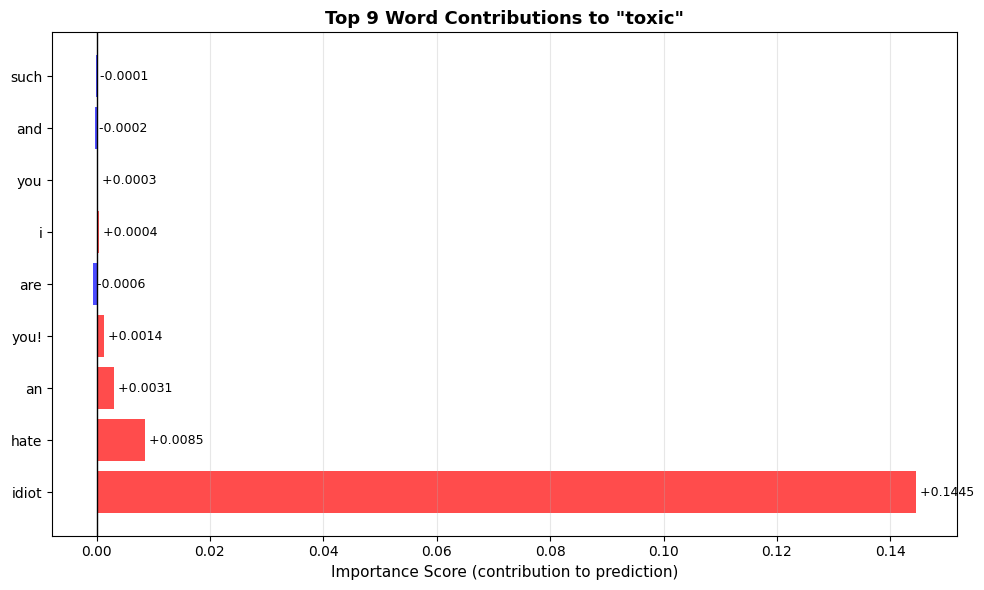

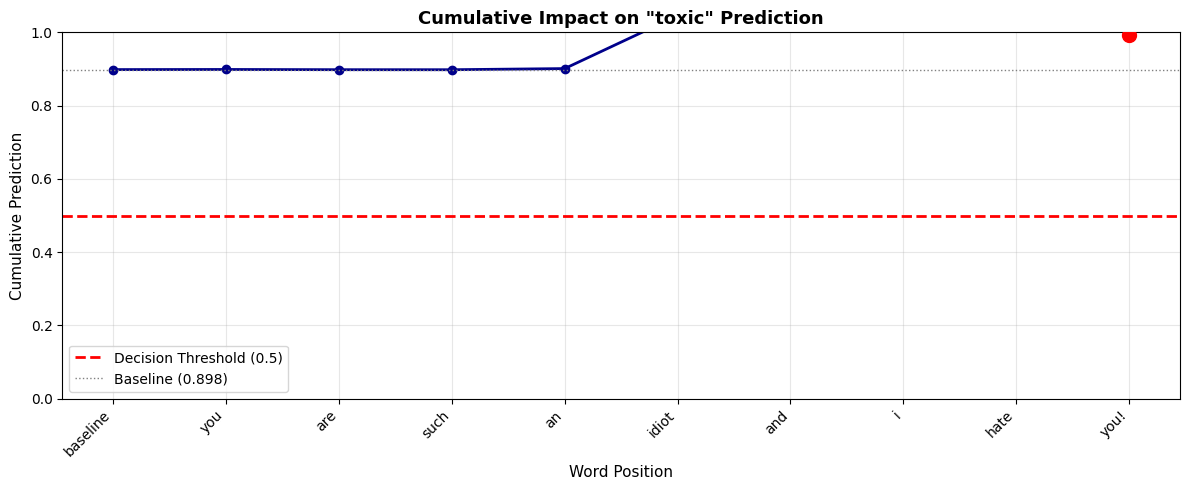

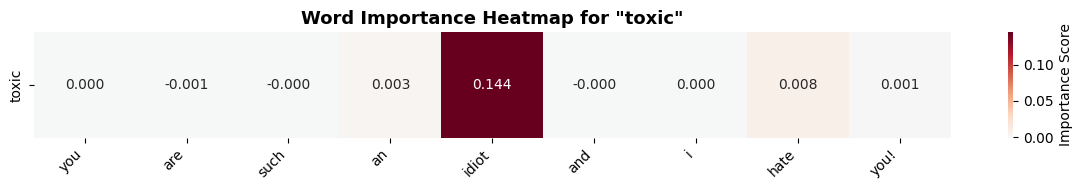


EXAMPLE 2: With Negation

📝 INPUT TEXT
You are not an idiot.

🎯 MODEL PREDICTIONS:
  🔴 toxic          : 0.9548 ████████████████████████████░░
  🟢 severe_toxic   : 0.0085 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  🔴 obscene        : 0.5005 ███████████████░░░░░░░░░░░░░░░
  🟢 threat         : 0.0009 ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
  🔴 insult         : 0.6918 ████████████████████░░░░░░░░░░
  🟢 identity_hate  : 0.0414 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

──────────────────────────────────────────────────────────────────────
Explaining: TOXIC
──────────────────────────────────────────────────────────────────────

📊 SUMMARY:
  Baseline (empty input): 0.8983
  Final prediction:       0.9548
  Total contribution:     +0.0564
  Average word impact:    0.1591

📝 Color-coded Text (threshold=0.05):
   🔴 Red = Increases toxicity | 🔵 Blue = Decreases toxicity | ⚪ Gray = Neutral

you are not an idiot. 


📋 TOP CONTRIBUTING WORDS:
Rank   Word                 Score        Impact
───────────────────────────────────────

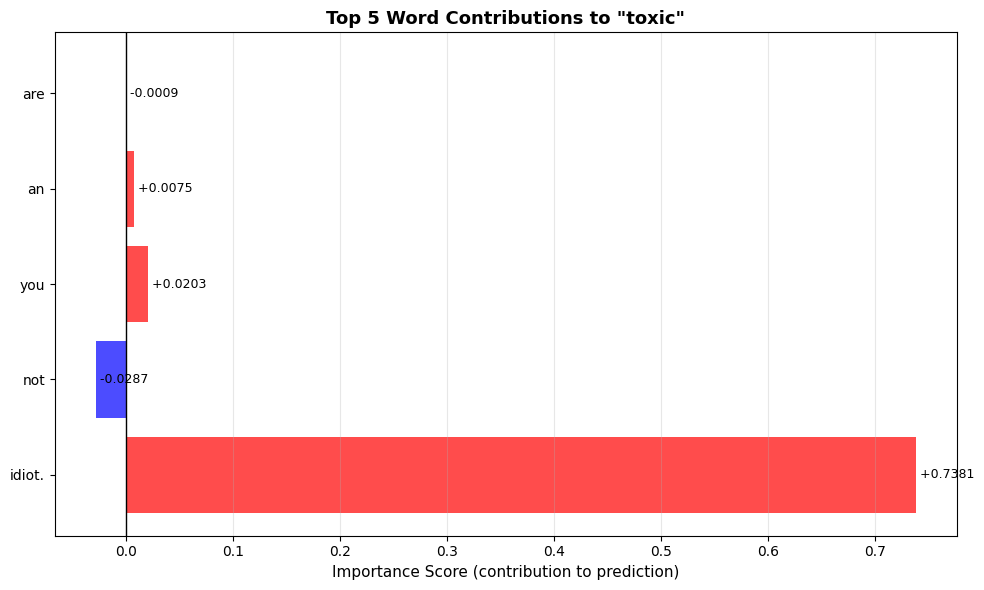

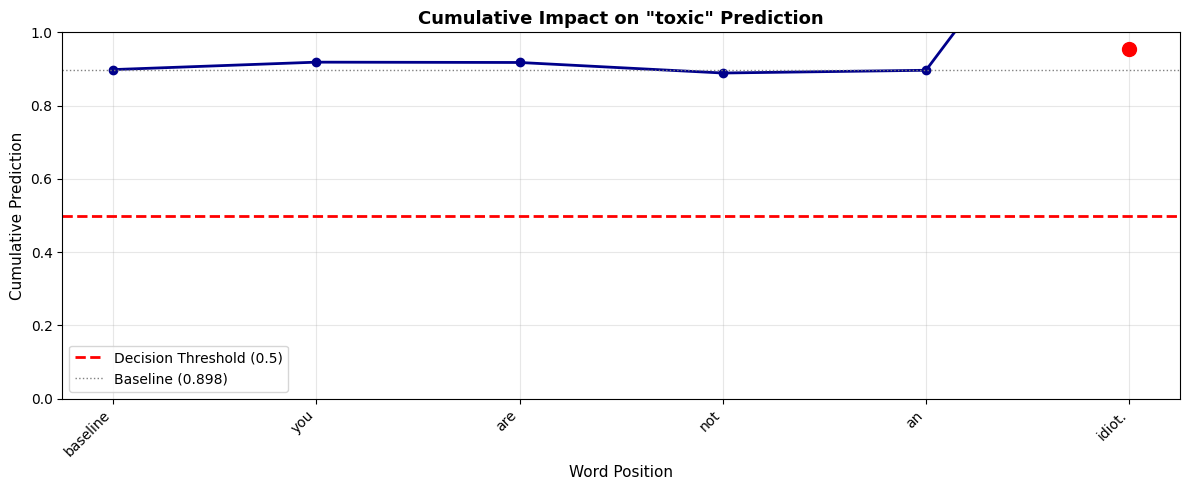

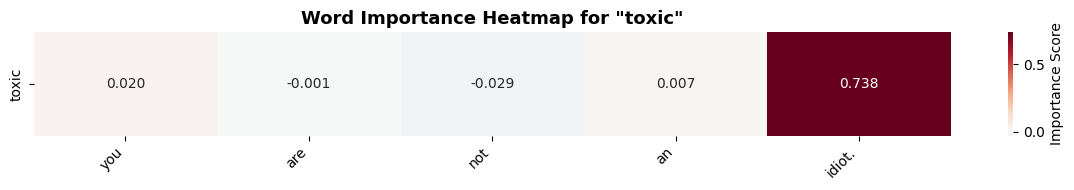


EXAMPLE 3: Severe Toxicity

📝 INPUT TEXT
You filthy disgusting person, go die!

🎯 MODEL PREDICTIONS:
  🔴 toxic          : 0.9190 ███████████████████████████░░░
  🟢 severe_toxic   : 0.2048 ██████░░░░░░░░░░░░░░░░░░░░░░░░
  🔴 obscene        : 0.6711 ████████████████████░░░░░░░░░░
  🔴 threat         : 0.8392 █████████████████████████░░░░░
  🔴 insult         : 0.5388 ████████████████░░░░░░░░░░░░░░
  🟢 identity_hate  : 0.0637 █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

──────────────────────────────────────────────────────────────────────
Explaining: TOXIC
──────────────────────────────────────────────────────────────────────

📊 SUMMARY:
  Baseline (empty input): 0.8983
  Final prediction:       0.9190
  Total contribution:     +0.0207
  Average word impact:    0.0132

📝 Color-coded Text (threshold=0.05):
   🔴 Red = Increases toxicity | 🔵 Blue = Decreases toxicity | ⚪ Gray = Neutral

you filthy disgusting person, go die! 


📋 TOP CONTRIBUTING WORDS:
Rank   Word                 Score        Impact
─────

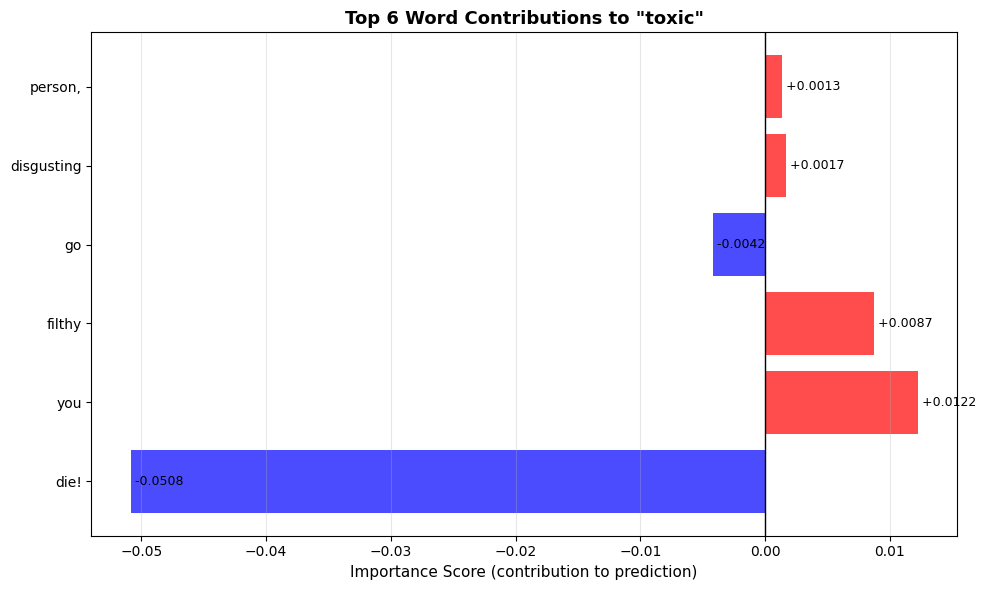

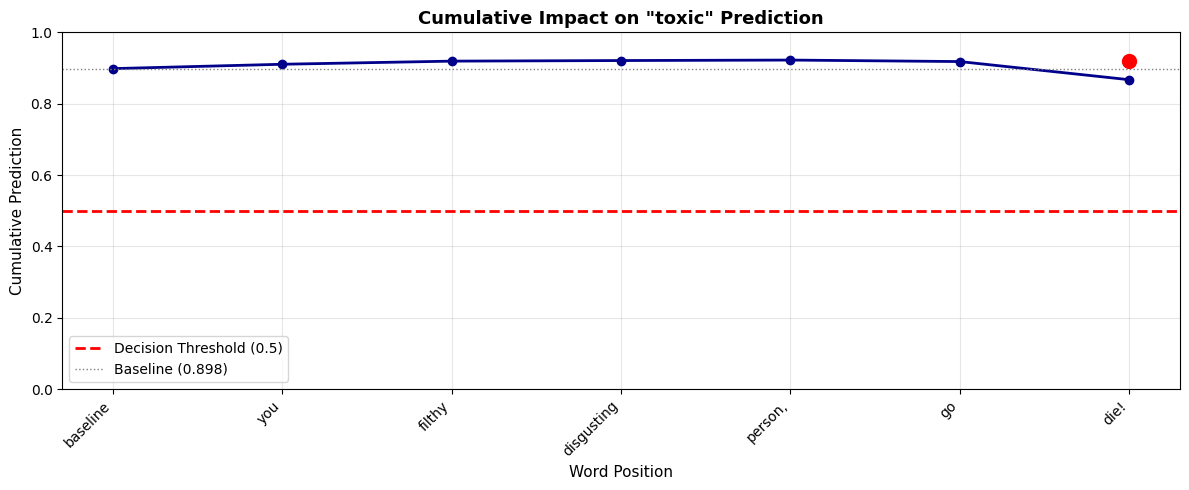

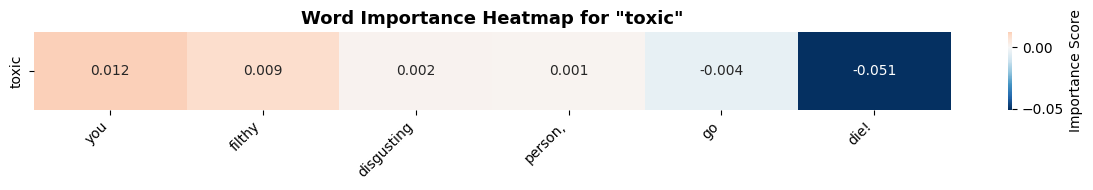


EXAMPLE 4: Negation Comparison

🧪 NEGATION ANALYSIS


──────────────────────────────────────────────────────────────────────
Comparing:
  ✅ WITHOUT negation: 'You are an idiot'
  ✅ WITH negation:    'You are not an idiot'
──────────────────────────────────────────────────────────────────────

📊 TOXIC PROBABILITY:
  Without negation: 0.9836
  With negation:    0.9552
  Change:           -0.0283 ✅ Reduced!

🔍 NEGATION WORD CONTRIBUTIONS:
  'not': -0.028306 → 🔵 Reduces toxicity

🔥 KEY TOXIC WORDS:
  'idiot': +0.377641
  'an': +0.008141
  'are': -0.003079

──────────────────────────────────────────────────────────────────────
Comparing:
  ✅ WITHOUT negation: 'I hate you'
  ✅ WITH negation:    'I don't hate you'
──────────────────────────────────────────────────────────────────────

📊 TOXIC PROBABILITY:
  Without negation: 0.8812
  With negation:    0.3969
  Change:           -0.4842 ✅ Reduced!

🔍 NEGATION WORD CONTRIBUTIONS:
  'don't': -0.484227 → 🔵 Reduces toxicity

🔥 KEY TOXIC WORDS:
  

In [ ]:
# ====================================================
# COMPLETE TOXIC COMMENT XAI SYSTEM
# (No SHAP dependencies - Custom Perturbation Method)
# ====================================================

import torch
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# ====================================================
# CONFIGURATION
# ====================================================
MODEL_PATH = "/content/toxic_output/best_model"
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
MAX_LEN = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ====================================================
# TEXT CLEANING
# ====================================================
def clean_text(text):
    if not isinstance(text, str):
        return ""
    url_pattern = r"http\S+|www\.\S+"
    html_pattern = r"<.*?>"
    emoji_pattern = r"[\U00010000-\U0010ffff]"
    non_ascii_pattern = r"[^\x00-\x7F]+"
    multi_space_pattern = r"\s+"

    text = text.lower()
    text = re.sub(url_pattern, " ", text)
    text = re.sub(html_pattern, " ", text)
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(non_ascii_pattern, " ", text)
    text = re.sub(multi_space_pattern, " ", text).strip()
    return text


# ====================================================
# LOAD MODEL & TOKENIZER
# ====================================================
print(f"📦 Loading model from: {MODEL_PATH}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()
print("✅ Model loaded successfully!")


# ====================================================
# EXPLAINER CLASS - WORD IMPORTANCE VIA PERTURBATION
# ====================================================
class ToxicityExplainer:
    """
    Explains model predictions using word-level perturbation
    Similar to SHAP but designed specifically for text
    """

    def __init__(self, model, tokenizer, device, max_len=256):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.max_len = max_len

    def predict(self, text: str) -> np.ndarray:
        """Get model predictions for a single text"""
        cleaned = clean_text(text)
        inputs = self.tokenizer(
            cleaned,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.sigmoid(outputs.logits).cpu().numpy().flatten()

        return probs

    def predict_batch(self, texts: List[str]) -> np.ndarray:
        """Get predictions for multiple texts"""
        all_probs = []
        for text in texts:
            probs = self.predict(text)
            all_probs.append(probs)
        return np.array(all_probs)

    def explain(self, text: str, label_idx: int = 0, method: str = "removal") -> Dict:
        """
        Generate word-level importance scores

        Args:
            text: Input text to explain
            label_idx: Which label to explain (0=toxic, etc.)
            method: "removal" (leave-one-out) or "masking" (replace with [MASK])

        Returns:
            Dictionary with tokens, importance scores, and metadata
        """
        cleaned = clean_text(text)
        words = cleaned.split()

        if len(words) == 0:
            return self._empty_explanation(label_idx)

        # Get baseline prediction (full text)
        base_prediction = self.predict(text)[label_idx]

        # Get empty baseline
        empty_prediction = self.predict("")[label_idx]

        # Calculate importance of each word
        word_importances = []

        for i in range(len(words)):
            if method == "removal":
                # Remove this word
                perturbed_words = words[:i] + words[i+1:]
                perturbed_text = " ".join(perturbed_words)
            else:  # masking
                # Replace with [MASK] token
                perturbed_words = words[:i] + ["[MASK]"] + words[i+1:]
                perturbed_text = " ".join(perturbed_words)

            # Get prediction without/with mask
            perturbed_prediction = self.predict(perturbed_text)[label_idx]

            # Importance = how much prediction changes when word is perturbed
            # Positive = word increases toxicity, Negative = decreases toxicity
            importance = base_prediction - perturbed_prediction
            word_importances.append(importance)

        return {
            'text': text,
            'tokens': words,
            'importance_scores': np.array(word_importances),
            'base_value': empty_prediction,
            'prediction': base_prediction,
            'label_idx': label_idx,
            'label_name': LABELS[label_idx]
        }

    def _empty_explanation(self, label_idx: int) -> Dict:
        """Return empty explanation for edge cases"""
        return {
            'text': "",
            'tokens': [],
            'importance_scores': np.array([]),
            'base_value': 0.0,
            'prediction': 0.0,
            'label_idx': label_idx,
            'label_name': LABELS[label_idx]
        }


# ====================================================
# INITIALIZE EXPLAINER
# ====================================================
print("🔧 Initializing Explainer...")
explainer = ToxicityExplainer(model, tokenizer, device, max_len=MAX_LEN)
print("✅ Explainer ready!")


# ====================================================
# VISUALIZATION FUNCTIONS
# ====================================================
def print_colored_text(explanation: Dict, threshold: float = 0.05):
    """Print text with color-coded word importance"""
    tokens = explanation['tokens']
    scores = explanation['importance_scores']

    print(f"\n📝 Color-coded Text (threshold={threshold}):")
    print("   🔴 Red = Increases toxicity | 🔵 Blue = Decreases toxicity | ⚪ Gray = Neutral\n")

    for token, score in zip(tokens, scores):
        if score > threshold:
            print(f"\033[91m{token}\033[0m", end=" ")  # Red
        elif score < -threshold:
            print(f"\033[94m{token}\033[0m", end=" ")  # Blue
        else:
            print(f"\033[90m{token}\033[0m", end=" ")  # Gray
    print("\n")


def plot_word_importance(explanation: Dict, top_k: int = 15):
    """Create horizontal bar chart of word importance"""
    tokens = explanation['tokens']
    scores = explanation['importance_scores']
    label = explanation['label_name']

    if len(tokens) == 0:
        print("⚠️ No tokens to visualize")
        return

    # Sort by absolute importance
    sorted_indices = np.argsort(np.abs(scores))[::-1][:top_k]
    top_tokens = [tokens[i] for i in sorted_indices]
    top_scores = scores[sorted_indices]

    # Create plot
    fig, ax = plt.subplots(figsize=(10, max(6, len(top_tokens) * 0.4)))

    colors = ['red' if s > 0 else 'blue' for s in top_scores]
    bars = ax.barh(range(len(top_tokens)), top_scores, color=colors, alpha=0.7)

    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels(top_tokens)
    ax.set_xlabel('Importance Score (contribution to prediction)', fontsize=11)
    ax.set_title(f'Top {len(top_tokens)} Word Contributions to "{label}"', fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, score) in enumerate(zip(bars, top_scores)):
        ax.text(score, i, f' {score:+.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()


def plot_cumulative_impact(explanation: Dict):
    """Show cumulative prediction as each word is added"""
    tokens = explanation['tokens']
    scores = explanation['importance_scores']
    base_value = explanation['base_value']
    prediction = explanation['prediction']
    label = explanation['label_name']

    if len(tokens) == 0:
        print("⚠️ No tokens to visualize")
        return

    # Calculate cumulative prediction
    cumulative = [base_value]
    for score in scores:
        cumulative.append(cumulative[-1] + score)

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 5))

    x_positions = range(len(cumulative))
    ax.plot(x_positions, cumulative, marker='o', linewidth=2, markersize=6, color='darkblue')

    # Add threshold line
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
    ax.axhline(y=base_value, color='gray', linestyle=':', linewidth=1, label=f'Baseline ({base_value:.3f})')

    # Styling
    ax.set_xlabel('Word Position', fontsize=11)
    ax.set_ylabel('Cumulative Prediction', fontsize=11)
    ax.set_title(f'Cumulative Impact on "{label}" Prediction', fontsize=13, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['baseline'] + tokens, rotation=45, ha='right')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    ax.set_ylim([0, 1])

    # Highlight final prediction
    ax.scatter([len(tokens)], [prediction], color='red', s=100, zorder=5, label=f'Final: {prediction:.3f}')

    plt.tight_layout()
    plt.show()


def plot_heatmap(explanation: Dict):
    """Create heatmap of word importance"""
    tokens = explanation['tokens']
    scores = explanation['importance_scores']
    label = explanation['label_name']

    if len(tokens) == 0:
        print("⚠️ No tokens to visualize")
        return

    # Reshape for heatmap
    scores_2d = scores.reshape(1, -1)

    fig, ax = plt.subplots(figsize=(max(12, len(tokens) * 0.5), 2))

    sns.heatmap(
        scores_2d,
        annot=True,
        fmt='.3f',
        cmap='RdBu_r',
        center=0,
        xticklabels=tokens,
        yticklabels=[label],
        cbar_kws={'label': 'Importance Score'},
        ax=ax
    )

    ax.set_title(f'Word Importance Heatmap for "{label}"', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# ====================================================
# MAIN EXPLANATION FUNCTION
# ====================================================
def explain_prediction(text: str, label_idx: int = 0, show_all_labels: bool = False,
                       method: str = "removal", visualize: bool = True):
    """
    Complete explanation pipeline for a text input

    Args:
        text: Input text
        label_idx: Which label to explain (default: 0 = toxic)
        show_all_labels: If True, explain all 6 labels
        method: "removal" or "masking"
        visualize: Show plots
    """
    print(f"\n{'='*70}")
    print(f"📝 INPUT TEXT")
    print(f"{'='*70}")
    print(f"{text}")
    print(f"{'='*70}\n")

    # Get all predictions
    all_probs = explainer.predict(text)

    print("🎯 MODEL PREDICTIONS:")
    for i, (label, prob) in enumerate(zip(LABELS, all_probs)):
        indicator = "🔴" if prob > 0.5 else "🟢"
        bar_length = int(prob * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"  {indicator} {label:15s}: {prob:.4f} {bar}")

    # Generate explanations
    if show_all_labels:
        explanations = []
        for idx in range(len(LABELS)):
            print(f"\n{'─'*70}")
            print(f"Explaining: {LABELS[idx].upper()}")
            print(f"{'─'*70}")

            exp = explainer.explain(text, label_idx=idx, method=method)
            explanations.append(exp)

            _display_explanation(exp, visualize=visualize)

        return explanations
    else:
        print(f"\n{'─'*70}")
        print(f"Explaining: {LABELS[label_idx].upper()}")
        print(f"{'─'*70}")

        explanation = explainer.explain(text, label_idx=label_idx, method=method)
        _display_explanation(explanation, visualize=visualize)

        return explanation


def _display_explanation(explanation: Dict, visualize: bool = True):
    """Helper to display a single explanation"""
    tokens = explanation['tokens']
    scores = explanation['importance_scores']
    base_value = explanation['base_value']
    prediction = explanation['prediction']
    label = explanation['label_name']

    if len(tokens) == 0:
        print("⚠️ No content to explain")
        return

    # Summary stats
    print(f"\n📊 SUMMARY:")
    print(f"  Baseline (empty input): {base_value:.4f}")
    print(f"  Final prediction:       {prediction:.4f}")
    print(f"  Total contribution:     {prediction - base_value:+.4f}")
    print(f"  Average word impact:    {np.mean(np.abs(scores)):.4f}")

    # Color-coded text
    print_colored_text(explanation)

    # Top words table
    print(f"\n📋 TOP CONTRIBUTING WORDS:")
    print(f"{'Rank':<6} {'Word':<20} {'Score':<12} {'Impact'}")
    print("─" * 60)

    sorted_indices = np.argsort(np.abs(scores))[::-1]
    for rank, idx in enumerate(sorted_indices[:10], 1):
        token = tokens[idx]
        score = scores[idx]
        impact = "🔴 Increases" if score > 0.05 else "🔵 Decreases" if score < -0.05 else "⚪ Neutral"
        print(f"{rank:<6} {token:<20} {score:>+.6f}    {impact}")

    # Visualizations
    if visualize:
        plot_word_importance(explanation, top_k=min(15, len(tokens)))
        plot_cumulative_impact(explanation)
        plot_heatmap(explanation)


# ====================================================
# NEGATION ANALYSIS
# ====================================================
def compare_negation():
    """Analyze how negation affects predictions"""
    print(f"\n{'='*70}")
    print("🧪 NEGATION ANALYSIS")
    print(f"{'='*70}\n")

    test_pairs = [
        ("You are an idiot", "You are not an idiot"),
        ("I hate you", "I don't hate you"),
        ("Go die", "Don't go die"),
        ("This is disgusting", "This is not disgusting"),
    ]

    for positive, negative in test_pairs:
        print(f"\n{'─'*70}")
        print(f"Comparing:")
        print(f"  ✅ WITHOUT negation: '{positive}'")
        print(f"  ✅ WITH negation:    '{negative}'")
        print(f"{'─'*70}")

        # Get predictions
        prob_pos = explainer.predict(positive)[0]  # Toxic label
        prob_neg = explainer.predict(negative)[0]

        # Get explanations
        exp_pos = explainer.explain(positive, label_idx=0)
        exp_neg = explainer.explain(negative, label_idx=0)

        # Results
        change = prob_neg - prob_pos
        print(f"\n📊 TOXIC PROBABILITY:")
        print(f"  Without negation: {prob_pos:.4f}")
        print(f"  With negation:    {prob_neg:.4f}")
        print(f"  Change:           {change:+.4f} {'✅ Reduced!' if change < 0 else '❌ Increased!'}")

        # Find negation words
        neg_tokens = exp_neg['tokens']
        neg_scores = exp_neg['importance_scores']

        negation_words = ['not', "don't", 'no', 'never', "won't", "can't", "shouldn't"]

        print(f"\n🔍 NEGATION WORD CONTRIBUTIONS:")
        found_negation = False
        for neg_word in negation_words:
            if neg_word in neg_tokens:
                idx = neg_tokens.index(neg_word)
                score = neg_scores[idx]
                effect = "🔵 Reduces toxicity" if score < 0 else "🔴 Increases toxicity" if score > 0 else "⚪ Neutral"
                print(f"  '{neg_word}': {score:+.6f} → {effect}")
                found_negation = True

        if not found_negation:
            print("  (No standard negation words found)")

        # Show key toxic words
        print(f"\n🔥 KEY TOXIC WORDS:")
        pos_sorted = np.argsort(np.abs(exp_pos['importance_scores']))[::-1][:3]
        for idx in pos_sorted:
            token = exp_pos['tokens'][idx]
            score = exp_pos['importance_scores'][idx]
            print(f"  '{token}': {score:+.6f}")


# ====================================================
# BATCH ANALYSIS
# ====================================================
def batch_analysis(texts: List[str], label_idx: int = 0):
    """Analyze multiple texts and aggregate insights"""
    print(f"\n{'='*70}")
    print(f"📦 BATCH ANALYSIS ({len(texts)} samples)")
    print(f"{'='*70}\n")

    all_explanations = []
    word_contributions = {}

    for i, text in enumerate(texts, 1):
        print(f"[{i}/{len(texts)}] Processing: '{text[:60]}{'...' if len(text) > 60 else ''}'")

        exp = explainer.explain(text, label_idx=label_idx)
        all_explanations.append(exp)

        # Aggregate word contributions
        for token, score in zip(exp['tokens'], exp['importance_scores']):
            if token not in word_contributions:
                word_contributions[token] = []
            word_contributions[token].append(score)

    # Calculate statistics
    word_stats = {
        word: {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'count': len(scores),
            'max': np.max(scores),
            'min': np.min(scores)
        }
        for word, scores in word_contributions.items()
    }

    # Sort by mean absolute impact
    sorted_words = sorted(
        word_stats.items(),
        key=lambda x: abs(x[1]['mean']),
        reverse=True
    )

    # Display results
    print(f"\n{'='*70}")
    print(f"📊 AGGREGATE RESULTS")
    print(f"{'='*70}\n")

    print(f"🔥 TOP 20 MOST IMPACTFUL WORDS (for {LABELS[label_idx]}):")
    print(f"{'Rank':<6} {'Word':<15} {'Avg Impact':<15} {'Std':<10} {'Freq':<8} {'Type'}")
    print("─" * 70)

    for rank, (word, stats) in enumerate(sorted_words[:20], 1):
        word_type = "🔴 Toxic" if stats['mean'] > 0.01 else "🔵 Safe" if stats['mean'] < -0.01 else "⚪ Neutral"
        print(f"{rank:<6} {word:<15} {stats['mean']:>+.6f}     {stats['std']:.4f}    {stats['count']:>3}x    {word_type}")

    # Prediction statistics
    predictions = [exp['prediction'] for exp in all_explanations]
    print(f"\n📈 PREDICTION STATISTICS:")
    print(f"  Mean:   {np.mean(predictions):.4f}")
    print(f"  Median: {np.median(predictions):.4f}")
    print(f"  Std:    {np.std(predictions):.4f}")
    print(f"  Range:  [{np.min(predictions):.4f}, {np.max(predictions):.4f}]")

    return all_explanations, word_stats


# ====================================================
# RUN EXAMPLES
# ====================================================

print("\n" + "="*70)
print("EXAMPLE 1: Basic Toxic Comment")
print("="*70)
exp1 = explain_prediction("You are such an idiot and I hate you!", label_idx=0)

print("\n" + "="*70)
print("EXAMPLE 2: With Negation")
print("="*70)
exp2 = explain_prediction("You are not an idiot.", label_idx=0)

print("\n" + "="*70)
print("EXAMPLE 3: Severe Toxicity")
print("="*70)
exp3 = explain_prediction("You filthy disgusting person, go die!", label_idx=0)

print("\n" + "="*70)
print("EXAMPLE 4: Negation Comparison")
print("="*70)
compare_negation()

print("\n" + "="*70)
print("EXAMPLE 5: Batch Analysis")
print("="*70)
test_samples = [
    "You are an idiot",
    "I will kill you",
    "This is disgusting filthy trash",
    "Have a great day",
    "You're not very smart",
    "Go die in a fire",
    "Thanks for sharing",
    "I hate your stupid face",
]
batch_results, word_stats = batch_analysis(test_samples, label_idx=0)

print("\n✅ ALL ANALYSES COMPLETE!")
print(f"{'='*70}\n")

✅ Using device: cuda
📦 Loading model from: /content/toxic_output/best_model
🔧 Initializing Word Perturbation Explainer...
✅ Explainer ready!

EXAMPLE 1: Basic Toxic Comment

📝 Input Text: 'You are such an idiot and I hate you!'

🎯 Predictions for all labels:
  🔴 toxic          : 0.9924 ███████████████████
  🟢 severe_toxic   : 0.1160 ██
  🔴 obscene        : 0.9076 ██████████████████
  🟢 threat         : 0.0045 
  🔴 insult         : 0.8743 █████████████████
  🟢 identity_hate  : 0.0856 █

📊 Explanation for: TOXIC
🎯 Base prediction (empty input): 0.8983
🎯 Final prediction (full text):  0.9924
🎯 Total contribution:            +0.0941

📝 Color-coded contributions (Red = increases toxicity, Blue = decreases):

⚪ you (+0.0003)  ⚪ are (-0.0006)  ⚪ such (-0.0001)  ⚪ an (+0.0031)  🔴 idiot (+0.1445)  ⚪ and (-0.0002)  ⚪ i (+0.0004)  ⚪ hate (+0.0085)  ⚪ you! (+0.0014)  


Token                Contribution    Impact    
--------------------------------------------------
idiot                +0.144494

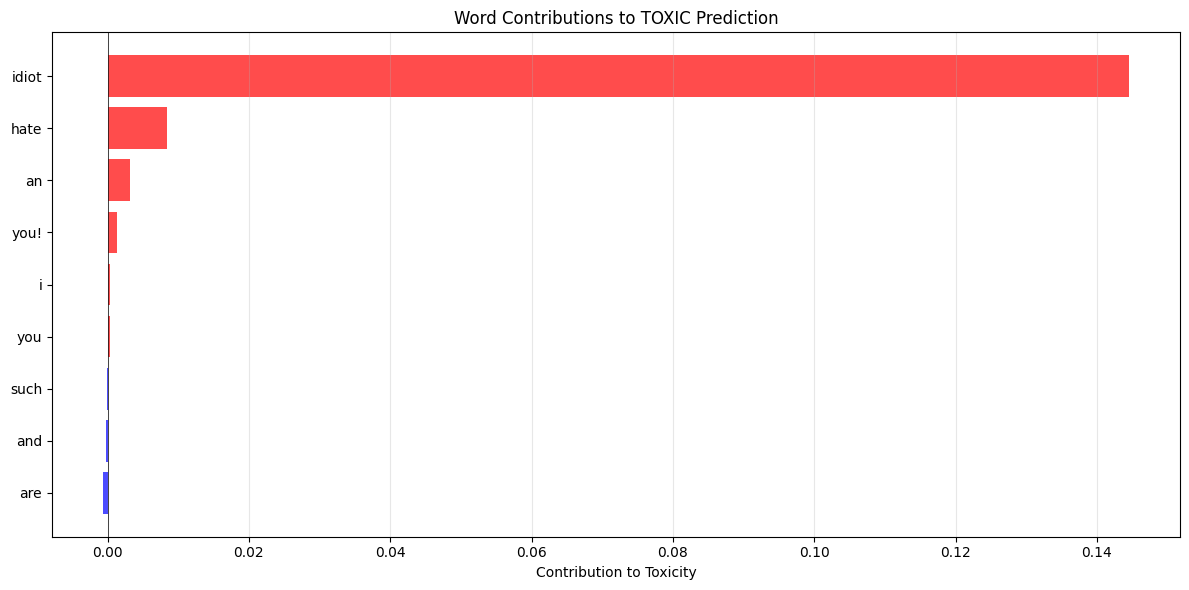

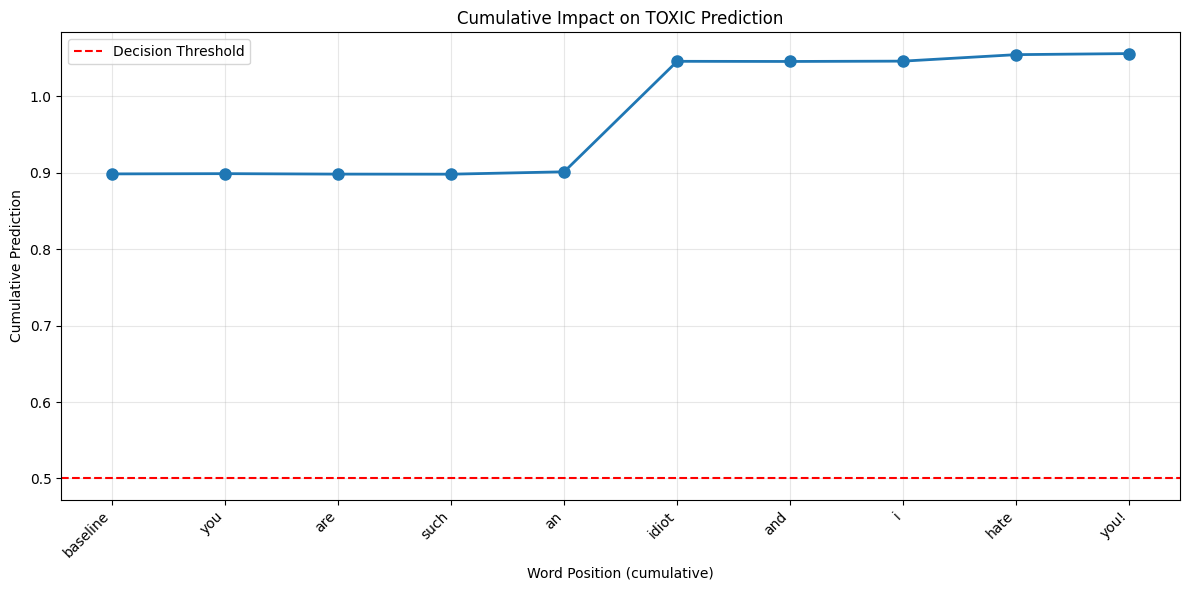


EXAMPLE 2: Negation Context

📝 Input Text: 'You are not an idiot.'

🎯 Predictions for all labels:
  🔴 toxic          : 0.9548 ███████████████████
  🟢 severe_toxic   : 0.0085 
  🔴 obscene        : 0.5005 ██████████
  🟢 threat         : 0.0009 
  🔴 insult         : 0.6918 █████████████
  🟢 identity_hate  : 0.0414 

📊 Explanation for: TOXIC
🎯 Base prediction (empty input): 0.8983
🎯 Final prediction (full text):  0.9548
🎯 Total contribution:            +0.0564

📝 Color-coded contributions (Red = increases toxicity, Blue = decreases):

⚪ you (+0.0203)  ⚪ are (-0.0009)  ⚪ not (-0.0287)  ⚪ an (+0.0075)  🔴 idiot. (+0.7381)  


Token                Contribution    Impact    
--------------------------------------------------
idiot.               +0.738118      🔴 Increases
not                  -0.028747      ⚪ Neutral
you                  +0.020275      🔴 Increases
an                   +0.007481      🔴 Increases
are                  -0.000879      ⚪ Neutral


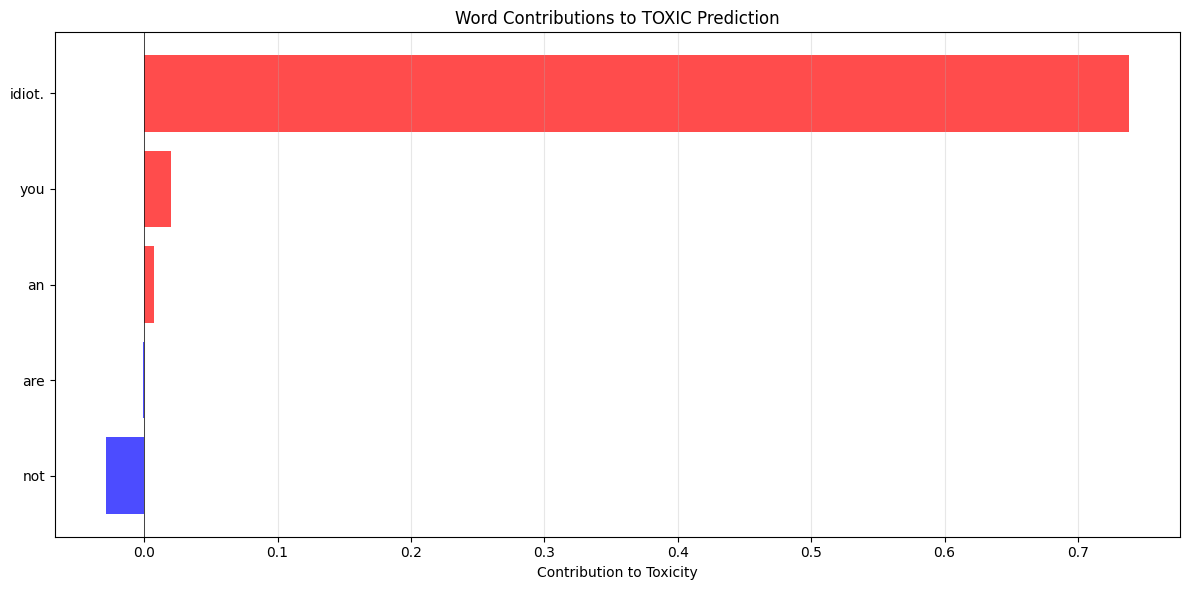

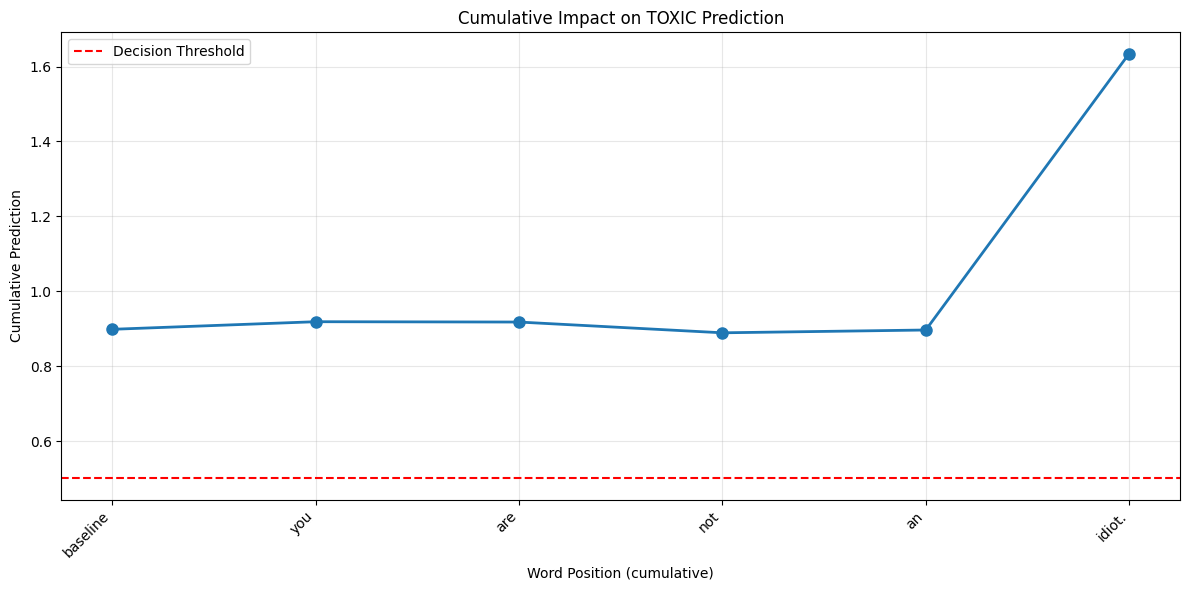


EXAMPLE 3: Severe Toxicity

📝 Input Text: 'You filthy disgusting person, go die!'

🎯 Predictions for all labels:
  🔴 toxic          : 0.9190 ██████████████████
  🟢 severe_toxic   : 0.2048 ████
  🔴 obscene        : 0.6711 █████████████
  🔴 threat         : 0.8392 ████████████████
  🔴 insult         : 0.5388 ██████████
  🟢 identity_hate  : 0.0637 █

📊 Explanation for: TOXIC
🎯 Base prediction (empty input): 0.8983
🎯 Final prediction (full text):  0.9190
🎯 Total contribution:            +0.0207

📝 Color-coded contributions (Red = increases toxicity, Blue = decreases):

⚪ you (+0.0122)  ⚪ filthy (+0.0087)  ⚪ disgusting (+0.0017)  ⚪ person, (+0.0013)  ⚪ go (-0.0042)  🔵 die! (-0.0508)  


Token                Contribution    Impact    
--------------------------------------------------
die!                 -0.050846      🔵 Decreases
you                  +0.012231      🔴 Increases
filthy               +0.008747      🔴 Increases
go                   -0.004205      ⚪ Neutral
disgusting         

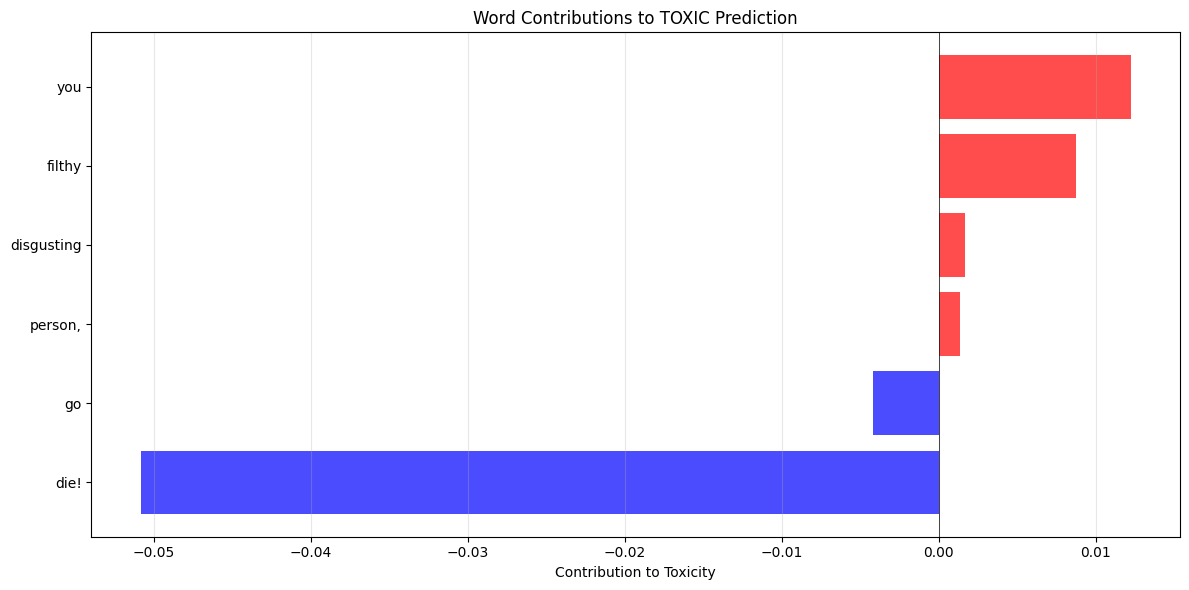

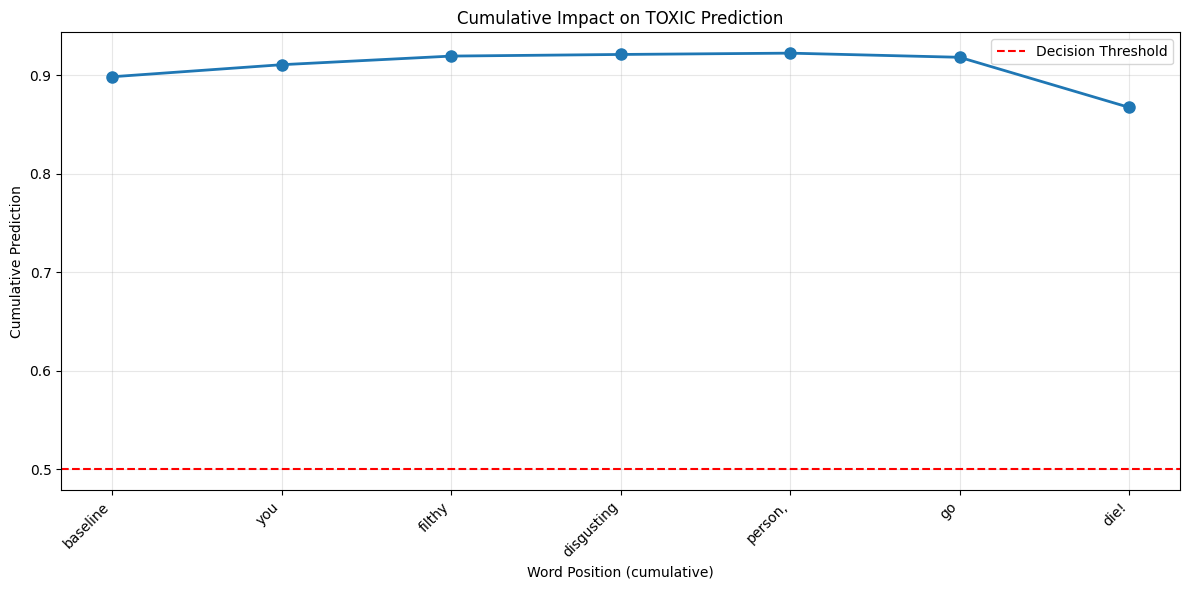


EXAMPLE 4: Comparative Negation Analysis

🧪 NEGATION & CONTEXT ANALYSIS


──────────────────────────────────────────────────────────────────────
Comparing:
  ✅ Phrase 1: 'You are an idiot'
  ✅ Phrase 2: 'You are not an idiot'
──────────────────────────────────────────────────────────────────────

📊 Toxic Probability:
  Without negation: 0.9836
  With negation:    0.9552
  Δ (change):       -0.0283 ✅ Reduced!

🔍 Negation Word Analysis:
  → 'not': -0.028306 🔵 Reduces toxicity

🔝 Top 3 words in version WITHOUT negation:
  → 'idiot': +0.377641
  → 'an': +0.008141
  → 'are': -0.003079

🔝 Top 3 words in version WITH negation:
  → 'idiot': +0.738594
  → 'not': -0.028306
  → 'you': +0.019286

──────────────────────────────────────────────────────────────────────
Comparing:
  ✅ Phrase 1: 'I hate you'
  ✅ Phrase 2: 'I don't hate you'
──────────────────────────────────────────────────────────────────────

📊 Toxic Probability:
  Without negation: 0.8812
  With negation:    0.3969
  Δ (change):   

In [ ]:
# ====================================================
# FIXED: TEXT-SPECIFIC SHAP IMPLEMENTATION
# ====================================================

import torch
import re
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import List, Dict, Tuple
import pandas as pd

# ====================================================
# CONFIGURATION
# ====================================================
MODEL_PATH = "/content/toxic_output/best_model"
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
MAX_LEN = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ====================================================
# CLEANING FUNCTION
# ====================================================
def clean_text(text):
    if not isinstance(text, str):
        return ""
    url_pattern = r"http\S+|www\.\S+"
    html_pattern = r"<.*?>"
    emoji_pattern = r"[\U00010000-\U0010ffff]"
    non_ascii_pattern = r"[^\x00-\x7F]+"
    multi_space_pattern = r"\s+"

    text = text.lower()
    text = re.sub(url_pattern, " ", text)
    text = re.sub(html_pattern, " ", text)
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(non_ascii_pattern, " ", text)
    text = re.sub(multi_space_pattern, " ", text).strip()
    return text


# ====================================================
# LOAD MODEL & TOKENIZER
# ====================================================
print(f"📦 Loading model from: {MODEL_PATH}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()


# ====================================================
# WORD-LEVEL PERTURBATION-BASED EXPLAINER
# ====================================================
class WordPerturbationExplainer:
    """
    Custom explainer using word-level perturbations
    Works by masking/removing each word and measuring impact on prediction
    """

    def __init__(self, model, tokenizer, device, baseline_token=""):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.baseline_token = baseline_token

    def predict(self, text: str) -> np.ndarray:
        """Get model prediction for a single text"""
        cleaned = clean_text(text)
        inputs = self.tokenizer(
            cleaned,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.sigmoid(outputs.logits).cpu().numpy().flatten()

        return probs

    def explain(self, text: str, label_idx: int = 0) -> Dict:
        """
        Generate word-level explanations using leave-one-out perturbation

        Returns:
            Dictionary with tokens, SHAP-like values, and predictions
        """
        # Clean and tokenize
        cleaned = clean_text(text)
        words = cleaned.split()

        if len(words) == 0:
            return {
                'tokens': [],
                'values': [],
                'base_value': 0.0,
                'prediction': 0.0
            }

        # Get baseline prediction (full text)
        base_prediction = self.predict(text)[label_idx]

        # Get prediction with empty input (baseline)
        empty_prediction = self.predict("")[label_idx]

        # Calculate contribution of each word
        word_contributions = []

        for i in range(len(words)):
            # Create text without this word
            perturbed_words = words[:i] + words[i+1:]
            perturbed_text = " ".join(perturbed_words)

            # Get prediction without this word
            perturbed_prediction = self.predict(perturbed_text)[label_idx]

            # Contribution = how much prediction drops when word is removed
            contribution = base_prediction - perturbed_prediction
            word_contributions.append(contribution)

        return {
            'tokens': words,
            'values': np.array(word_contributions),
            'base_value': empty_prediction,
            'prediction': base_prediction,
            'label': LABELS[label_idx]
        }


# ====================================================
# INITIALIZE EXPLAINER
# ====================================================
print("🔧 Initializing Word Perturbation Explainer...")
explainer = WordPerturbationExplainer(model, tokenizer, device)
print("✅ Explainer ready!")


# ====================================================
# VISUALIZATION FUNCTIONS
# ====================================================
def visualize_explanation(explanation: Dict, show_plot: bool = True):
    """
    Create visualization of word contributions
    """
    tokens = explanation['tokens']
    values = explanation['values']
    base_value = explanation['base_value']
    prediction = explanation['prediction']
    label = explanation['label']

    if len(tokens) == 0:
        print("⚠️ No tokens to visualize")
        return

    # Print summary
    print(f"\n{'='*70}")
    print(f"📊 Explanation for: {label.upper()}")
    print(f"{'='*70}")
    print(f"🎯 Base prediction (empty input): {base_value:.4f}")
    print(f"🎯 Final prediction (full text):  {prediction:.4f}")
    print(f"🎯 Total contribution:            {prediction - base_value:+.4f}")
    print(f"{'='*70}\n")

    # Create color-coded text output
    print("📝 Color-coded contributions (Red = increases toxicity, Blue = decreases):\n")

    for token, value in zip(tokens, values):
        # Determine color based on contribution
        if value > 0.05:
            color = '\033[91m'  # Red
            symbol = '🔴'
        elif value < -0.05:
            color = '\033[94m'  # Blue
            symbol = '🔵'
        else:
            color = '\033[90m'  # Gray
            symbol = '⚪'

        print(f"{symbol} {color}{token}\033[0m ({value:+.4f})", end="  ")

    print("\n")

    # Detailed token breakdown
    print(f"\n{'Token':<20} {'Contribution':<15} {'Impact':<10}")
    print("-" * 50)

    # Sort by absolute value
    sorted_indices = np.argsort(np.abs(values))[::-1]

    for idx in sorted_indices[:15]:  # Top 15
        token = tokens[idx]
        value = values[idx]
        impact = "🔴 Increases" if value > 0 else "🔵 Decreases" if value < -0.05 else "⚪ Neutral"
        print(f"{token:<20} {value:>+.6f}      {impact}")

    if not show_plot:
        return

    # Create bar plot
    plt.figure(figsize=(12, 6))

    # Sort by contribution value
    sorted_indices = np.argsort(values)
    sorted_tokens = [tokens[i] for i in sorted_indices]
    sorted_values = values[sorted_indices]

    # Color bars
    colors = ['red' if v > 0 else 'blue' for v in sorted_values]

    plt.barh(range(len(sorted_tokens)), sorted_values, color=colors, alpha=0.7)
    plt.yticks(range(len(sorted_tokens)), sorted_tokens)
    plt.xlabel('Contribution to Toxicity')
    plt.title(f'Word Contributions to {label.upper()} Prediction')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Waterfall-style cumulative plot
    plt.figure(figsize=(12, 6))

    cumulative = np.cumsum(np.concatenate([[base_value], values]))
    x_positions = range(len(cumulative))

    plt.plot(x_positions, cumulative, marker='o', linewidth=2, markersize=8)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold')
    plt.xlabel('Word Position (cumulative)')
    plt.ylabel('Cumulative Prediction')
    plt.title(f'Cumulative Impact on {label.upper()} Prediction')
    plt.xticks(x_positions, ['baseline'] + tokens, rotation=45, ha='right')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ====================================================
# MAIN EXPLANATION FUNCTION
# ====================================================
def explain_prediction(text: str, label_idx: int = 0, show_all_labels: bool = False):
    """
    Generate and visualize explanation for a text
    """
    print(f"\n{'='*70}")
    print(f"📝 Input Text: '{text}'")
    print(f"{'='*70}\n")

    # Get predictions for all labels
    probs = explainer.predict(text)

    print("🎯 Predictions for all labels:")
    for i, (label, prob) in enumerate(zip(LABELS, probs)):
        indicator = "🔴" if prob > 0.5 else "🟢"
        bar = "█" * int(prob * 20)
        print(f"  {indicator} {label:15s}: {prob:.4f} {bar}")

    # Generate explanations
    if show_all_labels:
        for idx in range(len(LABELS)):
            explanation = explainer.explain(text, label_idx=idx)
            visualize_explanation(explanation, show_plot=True)
    else:
        explanation = explainer.explain(text, label_idx=label_idx)
        visualize_explanation(explanation, show_plot=True)

    return explanation


# ====================================================
# NEGATION ANALYSIS
# ====================================================
def compare_negation_context():
    """
    Demonstrate how the model handles negation
    """
    print(f"\n{'='*70}")
    print("🧪 NEGATION & CONTEXT ANALYSIS")
    print(f"{'='*70}\n")

    test_pairs = [
        ("You are an idiot", "You are not an idiot"),
        ("I hate you", "I don't hate you"),
        ("Go die", "Don't go die"),
        ("This is disgusting", "This is not disgusting"),
    ]

    for positive, negative in test_pairs:
        print(f"\n{'─'*70}")
        print(f"Comparing:")
        print(f"  ✅ Phrase 1: '{positive}'")
        print(f"  ✅ Phrase 2: '{negative}'")
        print(f"{'─'*70}")

        # Get predictions
        probs_pos = explainer.predict(positive)[0]
        probs_neg = explainer.predict(negative)[0]

        # Get explanations
        exp_pos = explainer.explain(positive, label_idx=0)
        exp_neg = explainer.explain(negative, label_idx=0)

        print(f"\n📊 Toxic Probability:")
        print(f"  Without negation: {probs_pos:.4f}")
        print(f"  With negation:    {probs_neg:.4f}")
        print(f"  Δ (change):       {probs_neg - probs_pos:+.4f} {'✅ Reduced!' if probs_neg < probs_pos else '❌ Increased'}")

        # Analyze negation word contribution
        neg_tokens = exp_neg['tokens']
        neg_values = exp_neg['values']

        negation_words = ['not', "don't", 'no', 'never', "won't", "can't"]

        print(f"\n🔍 Negation Word Analysis:")
        for neg_word in negation_words:
            if neg_word in neg_tokens:
                idx = neg_tokens.index(neg_word)
                contribution = neg_values[idx]
                print(f"  → '{neg_word}': {contribution:+.6f} {'🔵 Reduces toxicity' if contribution < 0 else '🔴 Increases toxicity'}")

        # Show top contributing words in each version
        print(f"\n🔝 Top 3 words in version WITHOUT negation:")
        sorted_idx = np.argsort(np.abs(exp_pos['values']))[::-1][:3]
        for idx in sorted_idx:
            print(f"  → '{exp_pos['tokens'][idx]}': {exp_pos['values'][idx]:+.6f}")

        print(f"\n🔝 Top 3 words in version WITH negation:")
        sorted_idx = np.argsort(np.abs(exp_neg['values']))[::-1][:3]
        for idx in sorted_idx:
            print(f"  → '{exp_neg['tokens'][idx]}': {exp_neg['values'][idx]:+.6f}")


# ====================================================
# BATCH ANALYSIS
# ====================================================
def batch_explain(texts: List[str], label_idx: int = 0):
    """
    Analyze multiple texts and aggregate insights
    """
    print(f"\n{'='*70}")
    print(f"📦 BATCH ANALYSIS ({len(texts)} samples)")
    print(f"{'='*70}\n")

    all_results = []
    toxic_word_contributions = {}

    for i, text in enumerate(texts):
        print(f"Processing {i+1}/{len(texts)}: '{text[:50]}{'...' if len(text) > 50 else ''}'")

        explanation = explainer.explain(text, label_idx=label_idx)
        all_results.append(explanation)

        # Aggregate word contributions
        for token, value in zip(explanation['tokens'], explanation['values']):
            if token not in toxic_word_contributions:
                toxic_word_contributions[token] = []
            toxic_word_contributions[token].append(value)

    # Calculate statistics
    print(f"\n{'='*70}")
    print(f"📊 AGGREGATE RESULTS")
    print(f"{'='*70}\n")

    # Average contributions
    avg_contributions = {
        word: {
            'mean': np.mean(values),
            'std': np.std(values),
            'count': len(values)
        }
        for word, values in toxic_word_contributions.items()
    }

    # Sort by mean absolute contribution
    sorted_words = sorted(
        avg_contributions.items(),
        key=lambda x: abs(x[1]['mean']),
        reverse=True
    )

    print(f"🔥 TOP 20 MOST IMPACTFUL WORDS:")
    print(f"{'Word':<20} {'Avg Contribution':<20} {'Frequency':<12} {'Impact'}")
    print("─" * 70)

    for word, stats in sorted_words[:20]:
        impact = "🔴 Toxic" if stats['mean'] > 0 else "🔵 Safe"
        print(f"{word:<20} {stats['mean']:>+.6f} ± {stats['std']:.4f}    {stats['count']:>3}x        {impact}")

    # Prediction distribution
    predictions = [r['prediction'] for r in all_results]
    print(f"\n📈 Prediction Statistics for {LABELS[label_idx]}:")
    print(f"  Mean:   {np.mean(predictions):.4f}")
    print(f"  Median: {np.median(predictions):.4f}")
    print(f"  Std:    {np.std(predictions):.4f}")
    print(f"  Min:    {np.min(predictions):.4f}")
    print(f"  Max:    {np.max(predictions):.4f}")

    return all_results, toxic_word_contributions


# ====================================================
# EXAMPLE USAGE
# ====================================================

print("\n" + "="*70)
print("EXAMPLE 1: Basic Toxic Comment")
print("="*70)
explain_prediction("You are such an idiot and I hate you!", label_idx=0)

print("\n" + "="*70)
print("EXAMPLE 2: Negation Context")
print("="*70)
explain_prediction("You are not an idiot.", label_idx=0)

print("\n" + "="*70)
print("EXAMPLE 3: Severe Toxicity")
print("="*70)
explain_prediction("You filthy disgusting person, go die!", label_idx=0)

print("\n" + "="*70)
print("EXAMPLE 4: Comparative Negation Analysis")
print("="*70)
compare_negation_context()

print("\n" + "="*70)
print("EXAMPLE 5: Batch Analysis")
print("="*70)
test_samples = [
    "You are an idiot",
    "I will kill you",
    "This is disgusting filthy trash",
    "Have a great day",
    "You're not very smart",
    "Go die in a fire",
    "Thanks for sharing",
    "I hate your stupid face",
]
results, word_stats = batch_explain(test_samples, label_idx=0)

print("\n✅ All analyses complete!")

In [ ]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

SecretNotFoundError: Secret GOOGLE_API_KEY does not exist.

In [ ]:
# ==========================================================
# GEMINI 2.5 REWRITE COMPONENT + BERTSCORE EVALUATION
# ==========================================================

!pip install google-generativeai bert-score -q

import os
import torch
import pandas as pd
from bert_score import score as bert_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import google.generativeai as genai
from google.colab import userdata

# ----------------------------------------------------------
# 1️⃣  CONFIGURATION
# ----------------------------------------------------------
MODEL_PATH = "/content/toxic_output/best_model"  # your fine-tuned classifier
LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
THRESHOLD = 0.30  # below this → no rewrite
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure Gemini API
genai.configure(api_key=userdata.get('GEMINI_API_KEY'))
GEMINI_MODEL = "gemini-2.5-flash"

# Load toxicity classifier
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()

# ----------------------------------------------------------
# 2️⃣  HELPER FUNCTIONS
# ----------------------------------------------------------
def predict_toxicity(text):
    """Return dict of label:probability for given text"""
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy().flatten()
    return {label: float(prob) for label, prob in zip(LABELS, probs)}

def rewrite_with_gemini(text, toxicity_dict):
    """
    Convert toxic comments into constructive criticism using Gemini.
    Preserves the core message while removing offensive language.
    If all toxicity scores are below threshold, return original unchanged.
    """
    # Check if ALL toxicity scores are below threshold
    max_tox = max(toxicity_dict.values())
    if max_tox < THRESHOLD:
        print(f"   ℹ️  All toxicity scores below {THRESHOLD*100:.0f}%, no rewrite needed")
        return text

    # Format toxicity scores as percentages for the prompt
    tox_breakdown = "\n".join([f"  - {label}: {prob*100:.1f}%" for label, prob in toxicity_dict.items()])

    # Few-shot prompt with examples
    prompt = f"""You are a communication assistant that transforms toxic comments into constructive criticism. Your goal is to preserve the core message, opinion, and intent while removing offensive language and making it constructive.

TOXICITY ANALYSIS:
{tox_breakdown}

EXAMPLES OF GOOD TRANSFORMATIONS:

Example 1:
Toxic: "You are such an idiot and I hate you!"
Constructive: "I strongly disagree with your approach and find it frustrating."

Example 2:
Toxic: "This movie is garbage, only idiots would like it."
Constructive: "I found this movie disappointing and don't understand its appeal."

Example 3:
Toxic: "That guy is a complete moron."
Constructive: "I think that person made some poor decisions."

Example 4:
Toxic: "This politician is a liar and a thief."
Constructive: "I question this politician's honesty and integrity based on their actions."

Example 5:
Toxic: "I can't stand that disgusting singer."
Constructive: "I really dislike that singer's style and find it unappealing."

KEY PRINCIPLES:
- Keep the underlying opinion, critique, or sentiment
- Remove insults, slurs, and aggressive language
- Make it constructive and respectful
- Don't dilute the message - if someone is angry, show disagreement/frustration
- Don't lose the specificity of what they're criticizing
- Maintain the emotional intensity in a constructive way

Now transform this comment:
Original: "{text}"

Provide ONLY the constructive version, no explanations."""

    try:
        response = genai.GenerativeModel(GEMINI_MODEL).generate_content(prompt)
        rewritten = response.text.strip() if response.text else text
        return rewritten
    except Exception as e:
        print(f"   ⚠️  Gemini API error: {e}")
        return text

# ----------------------------------------------------------
# 3️⃣  SAMPLE COMMENTS
# ----------------------------------------------------------
comments = [
    "You are such an idiot and I hate you!",
    "You're amazing, keep up the good work!",
    "That guy is a complete moron.",
    "This movie is garbage, only idiots would like it.",
    "You did a terrible job at this presentation.",
    "I love spending time with my friends.",
    "This politician is a liar and a thief.",
    "Great job team, proud of you all!",
    "I can't stand that disgusting singer.",
    "The weather is perfect for a walk."
]

# ----------------------------------------------------------
# 4️⃣  RUN PIPELINE: PREDICT → REWRITE → EVALUATE
# ----------------------------------------------------------
originals, rewrites, toxicity_data = [], [], []

print("="*70)
print("PROCESSING COMMENTS")
print("="*70)

for i, comment in enumerate(comments, 1):
    print(f"\n[{i}/{len(comments)}] Processing...")
    print(f"🗣️  Original: {comment}")

    # STEP 1: Predict toxicity scores FIRST
    tox_scores = predict_toxicity(comment)
    print(f"⚖️  Toxicity Scores:")
    for label, score in tox_scores.items():
        print(f"      {label}: {score*100:.1f}%")

    # STEP 2: Rewrite based on toxicity scores
    rewritten = rewrite_with_gemini(comment, tox_scores)
    print(f"✍️  Rewritten: {rewritten}")

    # Store results
    originals.append(comment)
    rewrites.append(rewritten)
    toxicity_data.append(tox_scores)

# ----------------------------------------------------------
# 5️⃣  BERTSCORE EVALUATION
# ----------------------------------------------------------
print("\n" + "="*70)
print("BERTSCORE EVALUATION - SEMANTIC SIMILARITY")
print("="*70)
print("Comparing Original vs Rewritten (Higher score = better meaning preservation)\n")

# Calculate BERTScore: comparing rewritten TO original
P, R, F1 = bert_score(rewrites, originals, lang="en", verbose=False)

# Create detailed results DataFrame
results = []
for i, (orig, rew, p, r, f1) in enumerate(zip(originals, rewrites, P.tolist(), R.tolist(), F1.tolist())):
    results.append({
        "ID": i+1,
        "Original": orig,
        "Rewritten": rew,
        "Changed": "Yes" if orig != rew else "No",
        "Precision": f"{p:.4f}",
        "Recall": f"{r:.4f}",
        "F1": f"{f1:.4f}"
    })

df = pd.DataFrame(results)
print("✅ Semantic Similarity Results:")
display(df)

print(f"\n📊 Statistics:")
print(f"   Average BERTScore F1 (Semantic Similarity): {F1.mean().item():.4f}")
print(f"   Average Precision: {P.mean().item():.4f}")
print(f"   Average Recall: {R.mean().item():.4f}")
print(f"   Comments changed: {sum(1 for o, r in zip(originals, rewrites) if o != r)}/{len(originals)}")
print(f"   Comments unchanged: {sum(1 for o, r in zip(originals, rewrites) if o == r)}/{len(originals)}")

# Show only changed comments with their scores
changed_df = df[df["Changed"] == "Yes"].copy()
if len(changed_df) > 0:
    print(f"\n🔄 Changed Comments Analysis ({len(changed_df)} comments):")
    display(changed_df[["ID", "Original", "Rewritten", "Precision", "Recall", "F1"]])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


PROCESSING COMMENTS

[1/10] Processing...
🗣️  Original: You are such an idiot and I hate you!
⚖️  Toxicity Scores:
      toxic: 98.9%
      severe_toxic: 7.2%
      obscene: 86.1%
      threat: 0.3%
      insult: 85.3%
      identity_hate: 8.9%
✍️  Rewritten: I strongly disagree with your approach and find it frustrating.

[2/10] Processing...
🗣️  Original: You're amazing, keep up the good work!
⚖️  Toxicity Scores:
      toxic: 1.7%
      severe_toxic: 0.0%
      obscene: 0.1%
      threat: 0.0%
      insult: 0.0%
      identity_hate: 0.0%
   ℹ️  All toxicity scores below 30%, no rewrite needed
✍️  Rewritten: You're amazing, keep up the good work!

[3/10] Processing...
🗣️  Original: That guy is a complete moron.
⚖️  Toxicity Scores:
      toxic: 96.9%
      severe_toxic: 1.6%
      obscene: 60.1%
      threat: 0.1%
      insult: 75.3%
      identity_hate: 6.9%
✍️  Rewritten: I think that person made some poor decisions.

[4/10] Processing...
🗣️  Original: This movie is garbage, only i

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Semantic Similarity Results:


,ID,Original,Rewritten,Changed,Precision,Recall,F1
0,1,You are such an idiot and I hate you!,I strongly disagree with your approach and fin...,Yes,0.8897,0.8847,0.8872
1,2,"You're amazing, keep up the good work!","You're amazing, keep up the good work!",No,1.0000,1.0000,1.0000
2,3,That guy is a complete moron.,I think that person made some poor decisions.,Yes,0.9003,0.9040,0.9021
3,4,"This movie is garbage, only idiots would like it.",I found this movie disappointing and don't und...,Yes,0.9029,0.8962,0.8996
4,5,You did a terrible job at this presentation.,You did a terrible job at this presentation.,No,1.0000,1.0000,1.0000
5,6,I love spending time with my friends.,I love spending time with my friends.,No,1.0000,1.0000,1.0000
6,7,This politician is a liar and a thief.,I question this politician's honesty and integ...,Yes,0.8927,0.9227,0.9074
7,8,"Great job team, proud of you all!","Great job team, proud of you all!",No,1.0000,1.0000,1.0000
8,9,I can't stand that disgusting singer.,I really dislike that singer's style and find ...,Yes,0.9030,0.9299,0.9163
9,10,The weather is perfect for a walk.,The weather is perfect for a walk.,No,1.0000,1.0000,1.0000



📊 Statistics:
   Average BERTScore F1 (Semantic Similarity): 0.9513
   Average Precision: 0.9489
   Average Recall: 0.9538
   Comments changed: 5/10
   Comments unchanged: 5/10

🔄 Changed Comments Analysis (5 comments):


,ID,Original,Rewritten,Precision,Recall,F1
0,1,You are such an idiot and I hate you!,I strongly disagree with your approach and fin...,0.8897,0.8847,0.8872
2,3,That guy is a complete moron.,I think that person made some poor decisions.,0.9003,0.9040,0.9021
3,4,"This movie is garbage, only idiots would like it.",I found this movie disappointing and don't und...,0.9029,0.8962,0.8996
6,7,This politician is a liar and a thief.,I question this politician's honesty and integ...,0.8927,0.9227,0.9074
8,9,I can't stand that disgusting singer.,I really dislike that singer's style and find ...,0.9030,0.9299,0.9163
